In [6]:
 #brew install graphviz
 !pip install graphviz
from graphviz import Digraph
from IPython.display import display, SVG

In [11]:
class Value:
    def __init__(self, num, inputs = (), operation = "" ):
        self.num = num
        self.inputs = inputs
        self.operation = operation
        self.gradient = 0
        self._backward = lambda:None
        
        
    def __add__(self, other):   
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.num + other.num, (self, other), "+")
        
        def _backward():
            self.gradient += out.gradient
            other.gradient += out.gradient
        out._backward = _backward
        
        return out
    
    
    def __mul__(self, other):   
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.num * other.num, (self, other), "*")
        
        def _backward():
            self.gradient += other.num * out.gradient
            other.gradient += self.num * out.gradient
        out._backward = _backward   
        
        return out
    
    
    def __pow__(self, other):   
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.num ** other.num, (self, ), "^")
        
        def _backward():
            self.gradient += ((other.num * out.gradient) ** (other.num - 1)) * out.gradient
           
        out._backward = _backward   
        
        return out
    
    
    def relu(self):
        out = Value(max(0, self.num), (self,), "ReLU")
        
        def _backward():
            self.gradient += (out.num > 0) * out.gradient
        out._backward = _backward
        
        return out
    
    
   
    def backward(self): 
        self._backward()
        
        for val in self.inputs:
            val.backward();
        
        
    def __radd__(self, other):
        return self.__add__(other)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __rsub__(self, other):
        return Value(other).__sub__(self)
    
    def __repr__(self):
        return f"Value(num={self.num})"

In [12]:
def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.inputs:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    # Add nodes
    for n in nodes:
        dot.node(name=str(id(n)), label="{data %s | gradient=%.4f}" % (n.num, n.gradient), shape='record')
        if n.operation:  # If the node is a result of an operation
            dot.node(name=str(id(n)) + n.operation, label=n.operation)
            dot.edge(str(id(n)) + n.operation, str(id(n)))

    # Add edges
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operation)
    
    return dot

In [13]:
# Test Case 6: Chained Operations on the Same Instance
m = Value(3.0)
n = m ** m
n.gradient = 1
n.backward()



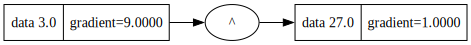

In [14]:
dot = draw_dot(n)
display(SVG(dot.pipe(format='svg')))